In [1]:
import sys

from my_units import *
from functions_model import * 
from functions_load import *
from functions_yellin import *
from functions_likelihood import *

i_p_str = '160' # this projection number corresponds to fiducial solar position
i_m_str = '120'

i_p = int(i_p_str) # projection number
i_m = int(i_m_str) # axion mass integer
print('i_p =',str(i_p),'| i_m =',str(i_m))

i_p = 160 | i_m = 120


In [2]:
# dir_home = '/mnt/home/kvantilburg/'
dir_ceph = '../' # for this to work, notebook must be run from 'code' directory
dir_source = dir_ceph+'data/likelihood_yellin_data/products_80610202001_orbit1_chu12_spatialARF/'
dir_events = dir_source+'event_lists/'
dir_production = dir_ceph+'data/production/'
dir_background = dir_ceph+'data/backgrounds/'
dir_res = dir_ceph+'results/data/'
dir_mcmc = dir_res+'mcmc/'

dir_proj = dir_res+'proj/proj_'+str(i_p)+'/'

file_rho0 = dir_proj+'rho0_'+str(i_p)+'_'+str(i_m)+'.csv'
file_proj = dir_proj+'proj_'+str(i_p)+'_'+str(i_m)+'.csv'

# time intervals [seconds]
good_time_ints = [
(  3.37603080e+08,   3.37603330e+08),
(  3.37603330e+08,   3.37603380e+08),
(  3.37603380e+08,   3.37603380e+08),
(  3.37603580e+08,   3.37603581e+08),
(  3.37603630e+08,   3.37605080e+08),
(  3.37605081e+08,   3.37605230e+08)]
exposure = np.sum([interval[1]-interval[0] for interval in good_time_ints])
livetime = np.asarray([1501.16599845754, 1481.86081041239])/exposure # effective fractional livetime of A and B
duration = np.max(good_time_ints)- np.min(good_time_ints)

# time bins
N_bins_t = 1 # make 10 later
bins_t = np.linspace(good_time_ints[0][0], good_time_ints[-1][1], N_bins_t+1)

# energy bins [units = keV]
sigma_E = 0.166 # energy resolution [keV]
n_sigma_E = 3
width_E = 0.04 # energy bin width is 40 keV
bins_E = np.arange(1.6,200.01,width_E)
list_m = np.arange(3,40,0.1)
m = list_m[i_m]  # axion mass [keV]

# fiducial solar position 
ra_sun_fid = 170.66855149 * degree
dec_sun_fid = 4.02092024 * degree
# error on solar position 
sigma_sun = 2 * arcmin
# shift in solar position over duration starting from t_min
delta_ra_sun = 0.01962028 * degree
delta_dec_sun = -0.00835105 * degree
t_min = 3.37603341e+08
sigma_sun = 2*arcmin # error on solar position

# initial solar position
ra_sun_0 = ra_sun_fid
dec_sun_0 = dec_sun_fid

list_file_events = np.sort([dir_events+file for file in listdir(dir_events)])
file_box_centers = dir_source+'box_centers.txt'
list_file_arf = [dir_source+'arfs/'+file for file in listdir(dir_source+'arfs/')]

In [3]:
##### load data #####
print('m = '+str(m)[0:8]+': initialized, loading data...')

df_data = load_data(m,sigma_E,good_time_ints,livetime,bins_t,bins_E,n_sigma_E,list_file_events,file_box_centers,list_file_arf)
t = df_data['t'].to_numpy()
E = df_data['E'].to_numpy()
ra = df_data['ra'].to_numpy()
dec = df_data['dec'].to_numpy()
exp = df_data['exp'].to_numpy()
arf = df_data['arf'].to_numpy()
eps = exp * arf * (df_data['Omega'].to_numpy() * arcmin**2 / (degree**2)) * width_E
counts = df_data['counts'].to_numpy()
df_data

m = 15.00000: initialized, loading data...


/Users/wderocco/Documents/Projects/Basin_X-rays/luminous-basin/code/functions_load.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_events = df_A.append(df_B)
/Users/wderocco/Documents/Projects/Basin_X-rays/luminous-basin/code/functions_load.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_data.append(tmp,ignore_index=True)
/Users/wderocco/Documents/Projects/Basin_X-rays/luminous-basin/code/functions_load.py:293: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_merge = df_data.append(df_events_bin) # merge source data and event data frames


,detector,idx_t,idx_E,i1,i2,t,E,ra,dec,exp,arf,Omega,counts
0,A,0,136,-6,-6,337603080.0,7.04,170.889,3.75981,1501.165998,110.276230,1.0,0
1,A,0,136,-6,-5,337603080.0,7.04,170.881,3.77425,1501.165998,80.678185,1.0,0
2,A,0,136,-6,-4,337603080.0,7.04,170.872,3.78868,1501.165998,134.188202,1.0,0
3,A,0,136,-6,-3,337603080.0,7.04,170.864,3.80311,1501.165998,132.737778,1.0,0
4,A,0,136,-6,-2,337603080.0,7.04,170.856,3.81755,1501.165998,233.203156,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8107,B,0,159,6,2,337603080.0,7.96,171.009,3.97187,1481.860810,134.420807,1.0,0
8108,B,0,159,6,3,337603080.0,7.96,171.001,3.98630,1481.860810,109.804642,1.0,0
8109,B,0,159,6,4,337603080.0,7.96,170.992,4.00073,1481.860810,79.109924,1.0,0
8110,B,0,159,6,5,337603080.0,7.96,170.984,4.01517,1481.860810,77.166641,1.0,0


In [11]:
df_data[df_data['counts'] > 0]['ra'].to_numpy()

array([170.897, 171.046, 170.851, 170.922, 170.903, 170.951, 170.99 ,
       170.94 , 170.806, 170.864, 170.923, 170.981, 170.898, 170.88 ,
       170.926, 170.904, 171.062, 171.025, 170.889, 171.031, 170.841,
       170.831, 171.076, 170.95 , 170.932, 170.966, 170.875, 170.844,
       170.9  , 170.811, 170.886, 171.009, 170.85 , 171.003, 170.825,
       170.931, 170.992, 170.834, 170.933, 171.022, 170.817, 170.944,
       171.005])

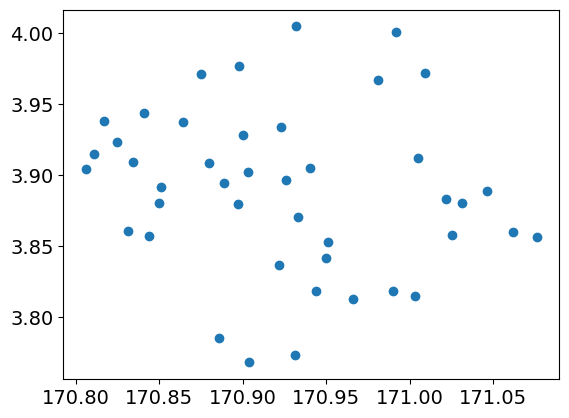

In [12]:
plt.scatter(df_data[df_data['counts'] > 0]['ra'].to_numpy(),df_data[df_data['counts'] > 0]['dec'].to_numpy())

In [20]:
df_data_not_m = load_data_not_m(m,sigma_E,good_time_ints,livetime,bins_t,bins_E,n_sigma_E,list_file_events,file_box_centers,list_file_arf)
E_not_m = df_data_not_m['E'].to_numpy()
exp_not_m = df_data_not_m['exp'].to_numpy()
counts_not_m = df_data_not_m['counts'].to_numpy()
df_data_not_m

/Users/wderocco/Documents/Projects/Basin_X-rays/luminous-basin/code/functions_load.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_events = df_A.append(df_B)
/Users/wderocco/Documents/Projects/Basin_X-rays/luminous-basin/code/functions_load.py:322: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_merge = df_data.append(df_events_bin_not_m) # merge source data and event data frames


,detector,idx_E,E,exp,counts
35,A,35,3.00,1501.165998,30
36,A,36,3.04,1501.165998,37
37,A,37,3.08,1501.165998,29
38,A,38,3.12,1501.165998,22
39,A,39,3.16,1501.165998,29
...,...,...,...,...,...
9917,B,4956,199.84,1481.860810,0
9918,B,4957,199.88,1481.860810,0
9919,B,4958,199.92,1481.860810,0
9920,B,4959,199.96,1481.860810,0


In [7]:
# Ken must include projection files.
df_tmp1 = pd.read_csv(file_rho0)
N_data = len(pd.read_csv(file_proj))
N_sig_lim_poisson = poisson_limit(N_data)
S_0_lim_poisson = N_sig_lim_poisson/df_tmp1['rho_0'][0]
S0_guess = S_0_lim_poisson
print('S0_guess = '+str(S0_guess)+' sec^{-1} degree^{-2} cm^{-2}')

FileNotFoundError: [Errno 2] No such file or directory: '../results/data/proj/proj_160/rho0_160_120.csv'

In [13]:
df_background = pd.read_csv(dir_background+'backgrounds.txt',delimiter=" ",skiprows=3,header=None)
df_background.columns = ["Energy [keV]","unknown","Total", "aCXB", "Internal","fXCB","Continuum"]
df_background

,Energy [keV],unknown,Total,aCXB,Internal,fXCB,Continuum
0,1.620000,0.020000,0.000185,3.594298e-05,1.808465e-06,0.000003,0.000144
1,1.660000,0.020000,0.000194,4.424206e-05,2.023978e-06,0.000003,0.000144
2,1.700000,0.020000,0.000204,5.304552e-05,2.230286e-06,0.000004,0.000145
3,1.740000,0.020000,0.000214,6.219269e-05,2.424499e-06,0.000004,0.000145
4,1.780000,0.020000,0.000225,7.193359e-05,2.609324e-06,0.000005,0.000145
...,...,...,...,...,...,...,...
4091,165.260010,0.019997,0.000229,2.040408e-08,9.147808e-08,0.000000,0.000229
4092,165.300003,0.020004,0.000229,1.926954e-08,8.636118e-08,0.000000,0.000229
4093,165.339996,0.019997,0.000229,1.805362e-08,8.088239e-08,0.000000,0.000229
4094,165.380005,0.019997,0.000229,1.691932e-08,7.578295e-08,0.000000,0.000229


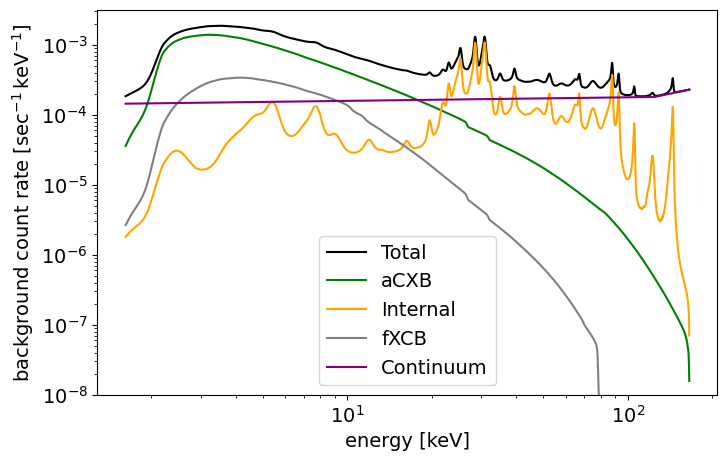

In [14]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(df_background['Energy [keV]'].to_numpy(),df_background['Total'].to_numpy(),label='Total',color=(0,0,0))
ax.plot(df_background['Energy [keV]'].to_numpy(),df_background['aCXB'].to_numpy(),label='aCXB',color='green')
ax.plot(df_background['Energy [keV]'].to_numpy(),df_background['Internal'].to_numpy(),label='Internal',color='orange')
ax.plot(df_background['Energy [keV]'].to_numpy(),df_background['fXCB'].to_numpy(),label='fXCB',color='gray')
ax.plot(df_background['Energy [keV]'].to_numpy(),df_background['Continuum'].to_numpy(),label='Continuum',color='purple')
#plt.plot(df_background['Energy [keV]'].to_numpy(dtype=float),df_background['unknown'].to_numpy(dtype=float),label='unknown')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(10**(-8),10**(-2.5))
ax.set_xlabel('energy [keV]')
ax.set_ylabel('background count rate [$\mathrm{sec^{-1} \, keV^{-1}}$]')
ax.legend();

In [16]:
E_bg = df_background['Energy [keV]'].to_numpy()
rate_total_bg = df_background['Total'].to_numpy()
rate_aCXB_bg = df_background['aCXB'].to_numpy()
rate_internal_bg = df_background['Internal'].to_numpy()
rate_fXCB_bg = df_background['fXCB'].to_numpy()
rate_continuum_bg = df_background['Continuum'].to_numpy()

int_rate_total_bg = interp1d(E_bg,rate_total_bg, fill_value='extrapolate')
int_rate_aCXB_bg = interp1d(E_bg, rate_aCXB_bg, fill_value='extrapolate')
int_rate_internal_bg = interp1d(E_bg, rate_internal_bg, fill_value='extrapolate')
int_rate_continuum_bg = interp1d(E_bg, rate_continuum_bg, fill_value='extrapolate')

# MCMC

In [23]:
# Background guesses from global fit:
B1_guess = 430.
B2_guess = 10.
gamma1_guess = -1.
gamma2_guess = -1.
B1_sigma = 50.
B2_sigma = 10.
gamma1_sigma = 1. # restricted artifically since negative values give nans
gamma2_sigma = 1.

S0_guess = 0.

p0_init = np.asarray([[B1_guess, B2_guess, gamma1_guess, gamma2_guess, S0_guess, ra_sun_fid, dec_sun_fid]])

In [27]:
# Background guesses from global fit:
B1_guess = 30.
B2_guess = 30.
gamma1_guess = -4.
gamma2_guess = -1.
B1_sigma = 10.
B2_sigma = 10.
gamma1_sigma = 0.3 
gamma2_sigma = 0.3

S0_guess = 0.0004

p0_init = np.asarray([[B1_guess, B2_guess, gamma1_guess, gamma2_guess, S0_guess, ra_sun_fid, dec_sun_fid]])

In [28]:
nwalkers = 15 # 32
ndim = 7 # B1,B2,gamma1,gamma2,S0,alpha0,delta0
p0_B1 = np.abs(np.random.normal(B1_guess,B1_sigma,nwalkers))
p0_B2 = np.abs(np.random.normal(B2_guess,B2_sigma,nwalkers))
# p0_gamma1 = np.abs(np.random.normal(gamma1_guess,gamma1_sigma,nwalkers))
# p0_gamma2 = np.abs(np.random.normal(gamma2_guess,gamma2_sigma,nwalkers))
p0_gamma1 = np.abs(np.random.uniform(-4,-1,nwalkers))
p0_gamma2 = np.abs(np.random.uniform(-4,-1,nwalkers))
p0_S0 = np.random.normal(S0_guess,0.1*S0_guess,nwalkers)
p0_ra_sun_0 = np.random.normal(ra_sun_fid,sigma_sun,nwalkers)
p0_dec_sun_0 = np.random.normal(dec_sun_fid,sigma_sun,nwalkers)
p0 = np.transpose([p0_B1,p0_B2,p0_gamma1,p0_gamma2,p0_S0,p0_ra_sun_0,p0_dec_sun_0])

In [129]:
import importlib
import functions_likelihood
importlib.reload(functions_likelihood)
from functions_likelihood import *

In [29]:
# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, LL, #backend=backend,
                                   args=[m,t,E,ra,dec,exp,eps,counts,exposure,width_E,sigma_E,
                                      t_min,delta_ra_sun,delta_dec_sun,sigma_sun,ra_sun_fid,dec_sun_fid,duration,
                                      E_not_m,exp_not_m,counts_not_m,
                                      int_rate_aCXB_bg,int_rate_internal_bg,int_rate_continuum_bg])

In [30]:
max_n = int(1e3) #int(1e5)
# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(p0, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

  0%|                                                                                                             | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 10%|█████████▉                                                                                         | 100/1000 [00:02<00:25, 34.70it/s]/usr/local/lib/python3.9/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.73it/s]


_____

In [31]:
np.max(sampler.get_log_prob())

-inf

In [132]:
np.max(sampler.get_log_prob())

-269.6446943512108

In [88]:
tau = sampler.get_autocorr_time(tol=0)
burnin = int(4 * np.max(tau))
thin = int(0.25 * np.min(tau))
samples_f = sampler.get_chain(discard=burnin, flat=True, thin=thin)
samples_w = sampler.get_chain(discard=burnin, flat=False, thin=thin)
print("mean tau: "+str(np.mean(tau))[0:6])
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("chain shape: {0}".format(samples_w.shape))

mean tau: 84.825
burn-in: 425
thin: 12
chain shape: (47, 15, 7)


In [133]:
tau = sampler.get_autocorr_time(tol=0)
burnin = int(4 * np.max(tau))
thin = int(0.25 * np.min(tau))
samples_f = sampler.get_chain(discard=burnin, flat=True, thin=thin)
samples_w = sampler.get_chain(discard=burnin, flat=False, thin=thin)
print("mean tau: "+str(np.mean(tau))[0:6])
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("chain shape: {0}".format(samples_w.shape))

mean tau: 78.969
burn-in: 365
thin: 16
chain shape: (39, 15, 7)


In [90]:
p_out_f = np.asarray([np.percentile(samples_f[:,i],[14,50,86]) for i in range(np.shape(samples_f)[1])])
p_out_w = np.asarray([[np.percentile(samples_w[:,i,j],[14,50,86]) for j in range(np.shape(samples_w)[2])] for i in range(np.shape(samples_w)[1])])
print(p_out_f[:,1])

[ 6.46603781e+01  8.07594714e+00 -4.42014189e+00 -8.55103611e-01
  4.32013313e-04  2.97619048e+00  6.77283771e-02]


In [134]:
p_out_f = np.asarray([np.percentile(samples_f[:,i],[14,50,86]) for i in range(np.shape(samples_f)[1])])
p_out_w = np.asarray([[np.percentile(samples_w[:,i,j],[14,50,86]) for j in range(np.shape(samples_w)[2])] for i in range(np.shape(samples_w)[1])])
print(p_out_f[:,1])

[ 5.17069308e+01  1.44974137e+02 -4.27170880e+00 -1.14165487e+01
  2.09935000e-04  2.97847580e+00  7.00944616e-02]


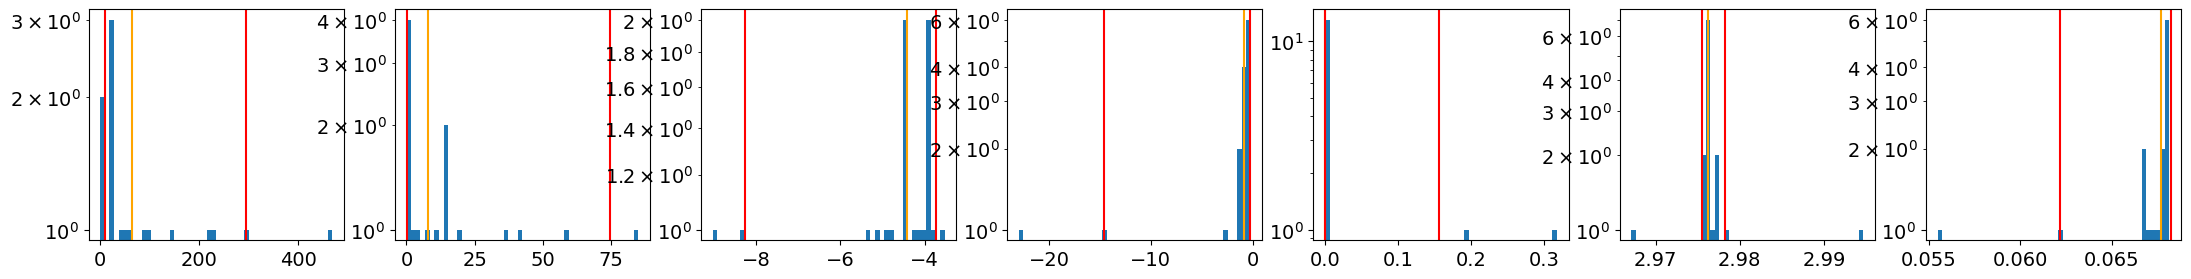

In [99]:
fig,ax = plt.subplots(1,7,figsize=(27,3))
for j in range(p_out_w.shape[1]):
    ax[j].hist(p_out_w[:,j,1],bins=50,log=True);
    ax[j].axvline(p_out_f[j,1],color='orange')
    ax[j].axvline(p_out_f[j,0],color='red')
    ax[j].axvline(p_out_f[j,2],color='red')

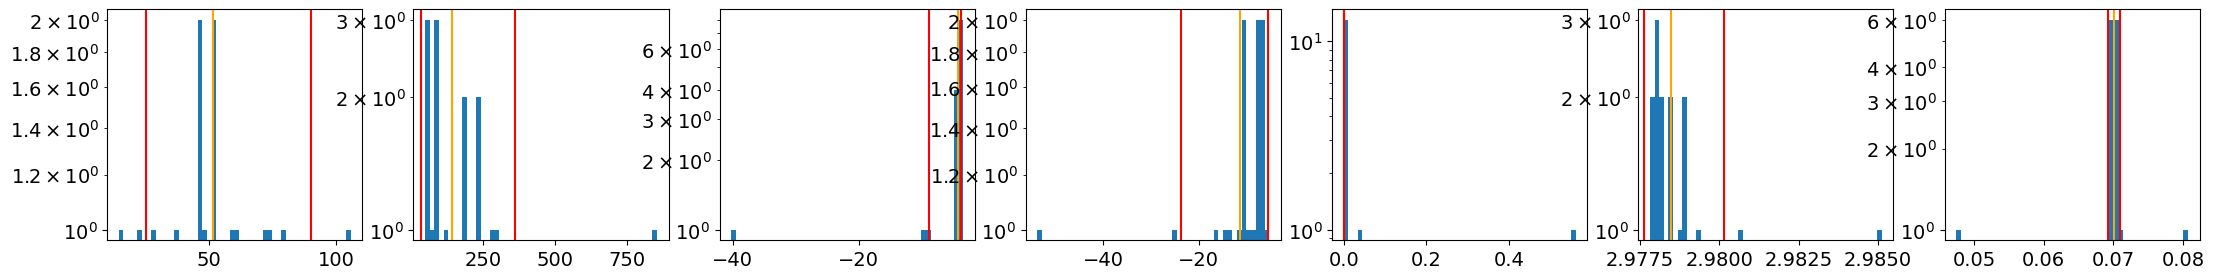

In [135]:
fig,ax = plt.subplots(1,7,figsize=(27,3))
for j in range(p_out_w.shape[1]):
    ax[j].hist(p_out_w[:,j,1],bins=50,log=True);
    ax[j].axvline(p_out_f[j,1],color='orange')
    ax[j].axvline(p_out_f[j,0],color='red')
    ax[j].axvline(p_out_f[j,2],color='red')

In [136]:
#flag_keep_w = np.ones(nwalkers)
flag_keep_w = np.asarray(nwalkers * [True])
for i_w in range(nwalkers):
    for i_d in range(ndim):
        if (p_out_w[i_w,i_d,1] < p_out_f[i_d,0]) or (p_out_w[i_w,i_d,1] > p_out_f[i_d,2]):
            flag_keep_w[i_w] = False
            print('stray walker: '+'i_w = '+str(i_w)+', i_d = '+str(i_d))

stray walker: i_w = 3, i_d = 3
stray walker: i_w = 3, i_d = 4
stray walker: i_w = 3, i_d = 6
stray walker: i_w = 6, i_d = 2
stray walker: i_w = 6, i_d = 4
stray walker: i_w = 6, i_d = 5
stray walker: i_w = 6, i_d = 6
stray walker: i_w = 7, i_d = 0
stray walker: i_w = 10, i_d = 0
stray walker: i_w = 10, i_d = 3
stray walker: i_w = 13, i_d = 0
stray walker: i_w = 13, i_d = 2
stray walker: i_w = 14, i_d = 1
stray walker: i_w = 14, i_d = 2
stray walker: i_w = 14, i_d = 3
stray walker: i_w = 14, i_d = 5


In [137]:
print('shape(samples_w) = '+str(samples_w.shape))
print('shape(samples_f) = '+str(samples_f.shape))
samples = samples_w[:,flag_keep_w,:]
samples = samples.reshape((samples.shape[0]*samples.shape[1], samples.shape[2]))
print('shape(samples) = '+str(samples.shape))

shape(samples_w) = (39, 15, 7)
shape(samples_f) = (585, 7)
shape(samples) = (351, 7)


In [138]:
p_out = np.asarray([np.percentile(samples[:,i],[1,16,50,84,99]) for i in range(np.shape(samples)[1])])

In [95]:
[B1_fit, B2_fit, gamma1_fit, gamma2_fit, S0_fit, ra_sun_fit, dec_sun_fit] = p_out[:,2]
print('[B1_guess, B2_guess, gamma1_guess, gamma2_guess, S0_guess, ra_sun_fid, dec_sun_fid] =\n',
      str([B1_guess, B2_guess, gamma1_guess, gamma2_guess, S0_guess, ra_sun_fid, dec_sun_fid]))
print('[B1_fit, B2_fit, gamma1_fit, gamma2_fit, S0_fit, ra_sun_fit, dec_sun_fit] =\n',
      str([B1_fit, B2_fit, gamma1_fit, gamma2_fit, S0_fit, ra_sun_fit, dec_sun_fit]))
print('sigmas =\n',str((p_out[:,3]-p_out[:,1])/2))

[B1_guess, B2_guess, gamma1_guess, gamma2_guess, S0_guess, ra_sun_fid, dec_sun_fid] =
 [30.0, 30.0, -2.0, -2.0, 3.0, 2.9787281531099743, 0.07017829714808059]
[B1_fit, B2_fit, gamma1_fit, gamma2_fit, S0_fit, ra_sun_fit, dec_sun_fit] =
 [72.1749207970007, 10.664874507142542, -4.3610736813873885, -0.7974333410211834, 0.0004139066306800885, 2.9761376773589863, 0.06786578963729234]
sigmas =
 [1.26770273e+02 3.87406974e+01 6.54907091e-01 6.93737449e-01
 2.84903107e-04 4.33249984e-04 5.52695221e-04]


In [139]:
[B1_fit, B2_fit, gamma1_fit, gamma2_fit, S0_fit, ra_sun_fit, dec_sun_fit] = p_out[:,2]
print('[B1_guess, B2_guess, gamma1_guess, gamma2_guess, S0_guess, ra_sun_fid, dec_sun_fid] =\n',
      str([B1_guess, B2_guess, gamma1_guess, gamma2_guess, S0_guess, ra_sun_fid, dec_sun_fid]))
print('[B1_fit, B2_fit, gamma1_fit, gamma2_fit, S0_fit, ra_sun_fit, dec_sun_fit] =\n',
      str([B1_fit, B2_fit, gamma1_fit, gamma2_fit, S0_fit, ra_sun_fit, dec_sun_fit]))
print('sigmas =\n',str((p_out[:,3]-p_out[:,1])/2))

[B1_guess, B2_guess, gamma1_guess, gamma2_guess, S0_guess, ra_sun_fid, dec_sun_fid] =
 [30.0, 30.0, -2.0, -2.0, 3.0, 2.9787281531099743, 0.07017829714808059]
[B1_fit, B2_fit, gamma1_fit, gamma2_fit, S0_fit, ra_sun_fit, dec_sun_fit] =
 [53.27381255803677, 110.10909277162503, -4.2194835643900515, -9.718812060594296, 0.00013973519024078522, 2.9782545222432733, 0.07011852203524932]
sigmas =
 [2.66812138e+01 1.34315328e+02 2.90259786e-01 5.13038876e+00
 1.37964393e-04 7.23672287e-04 7.19186521e-04]


## Plots

### MCMC convergence

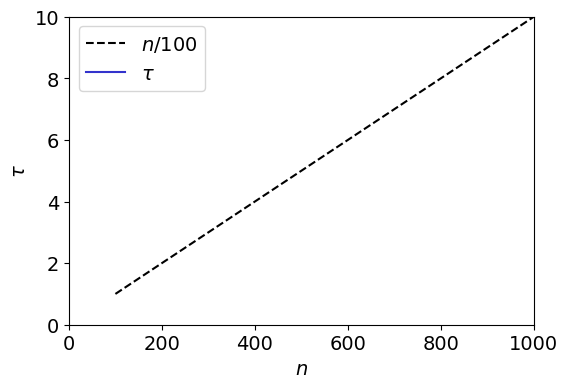

In [96]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
vec_n = 100 * np.arange(1, index + 1)
vec_autocorr = autocorr[:index]
ax.plot(vec_n, vec_n / 100, color=(0,0,0), ls='dashed', label='$n/100$');
ax.plot(vec_n, vec_autocorr, color=(0.2,0.2,0.8), ls='solid', label=r'$\tau$');
ax.set_xlim(0,vec_n[-1]); ax.set_ylim(0,vec_n[-1]/100);
ax.legend(); ax.set_xlabel('$n$'); ax.set_ylabel(r'$\tau$');

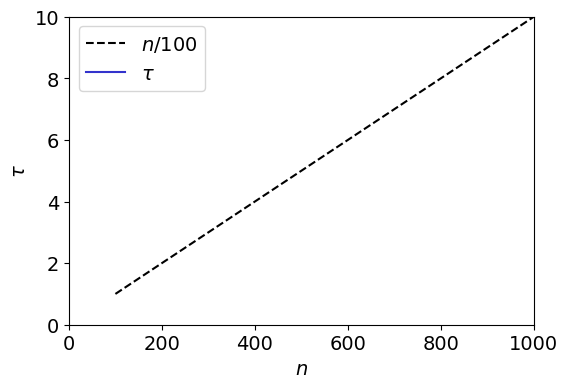

In [140]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
vec_n = 100 * np.arange(1, index + 1)
vec_autocorr = autocorr[:index]
ax.plot(vec_n, vec_n / 100, color=(0,0,0), ls='dashed', label='$n/100$');
ax.plot(vec_n, vec_autocorr, color=(0.2,0.2,0.8), ls='solid', label=r'$\tau$');
ax.set_xlim(0,vec_n[-1]); ax.set_ylim(0,vec_n[-1]/100);
ax.legend(); ax.set_xlabel('$n$'); ax.set_ylabel(r'$\tau$');

In [141]:
samples_w = sampler.get_chain(discard=0,thin=thin)

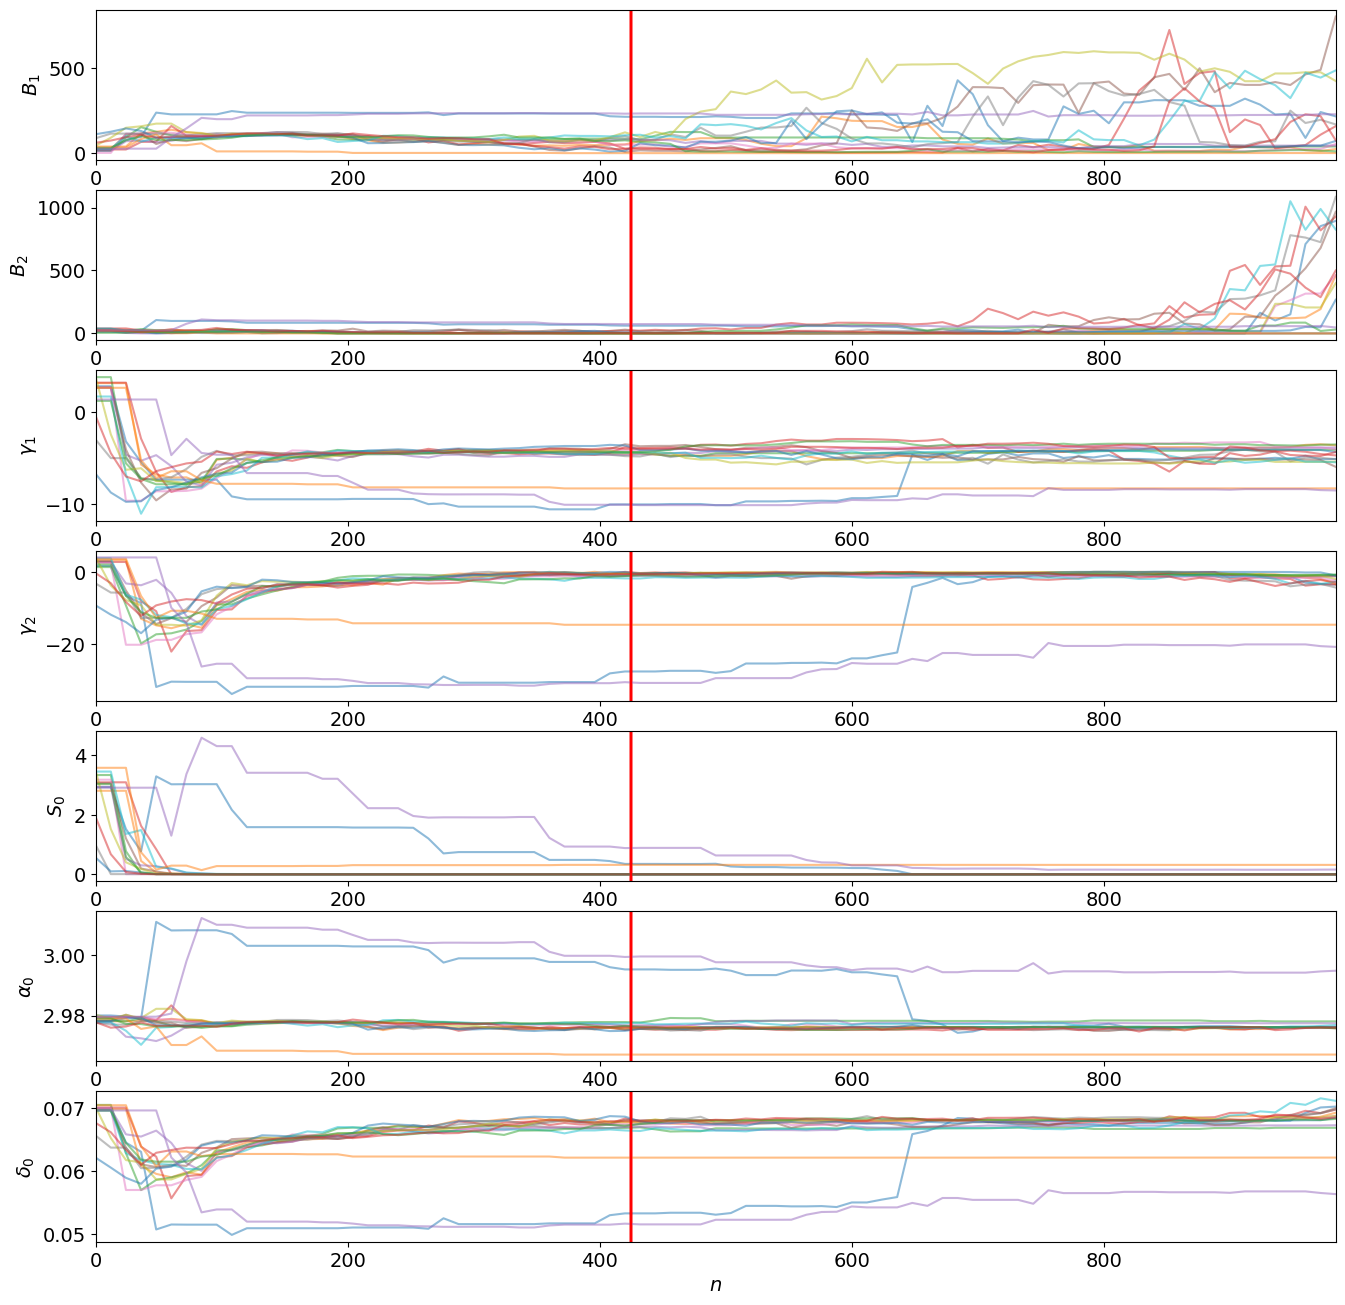

In [98]:
fig,ax = plt.subplots(ndim,1,figsize=(16,16))
labels = [r'$B_1$',r'$B_2$',r'$\gamma_1$',r'$\gamma_2$',r'$S_0$',r'$\alpha_0$',r'$\delta_0$']
for j in range(ndim):
    for i in range(nwalkers):
        ax[j].plot(thin*np.arange(len(samples_w)),samples_w[:,i,j],alpha=0.5)
        ax[j].set_xlim(0,thin*(len(samples_w)-1))
        #ax[j].set_xlim(0,vec_n[-1])
        ax[j].axvline(burnin,color='red')
        ax[j].set_ylabel(labels[j])
ax[ndim-1].set_xlabel(r'$n$');

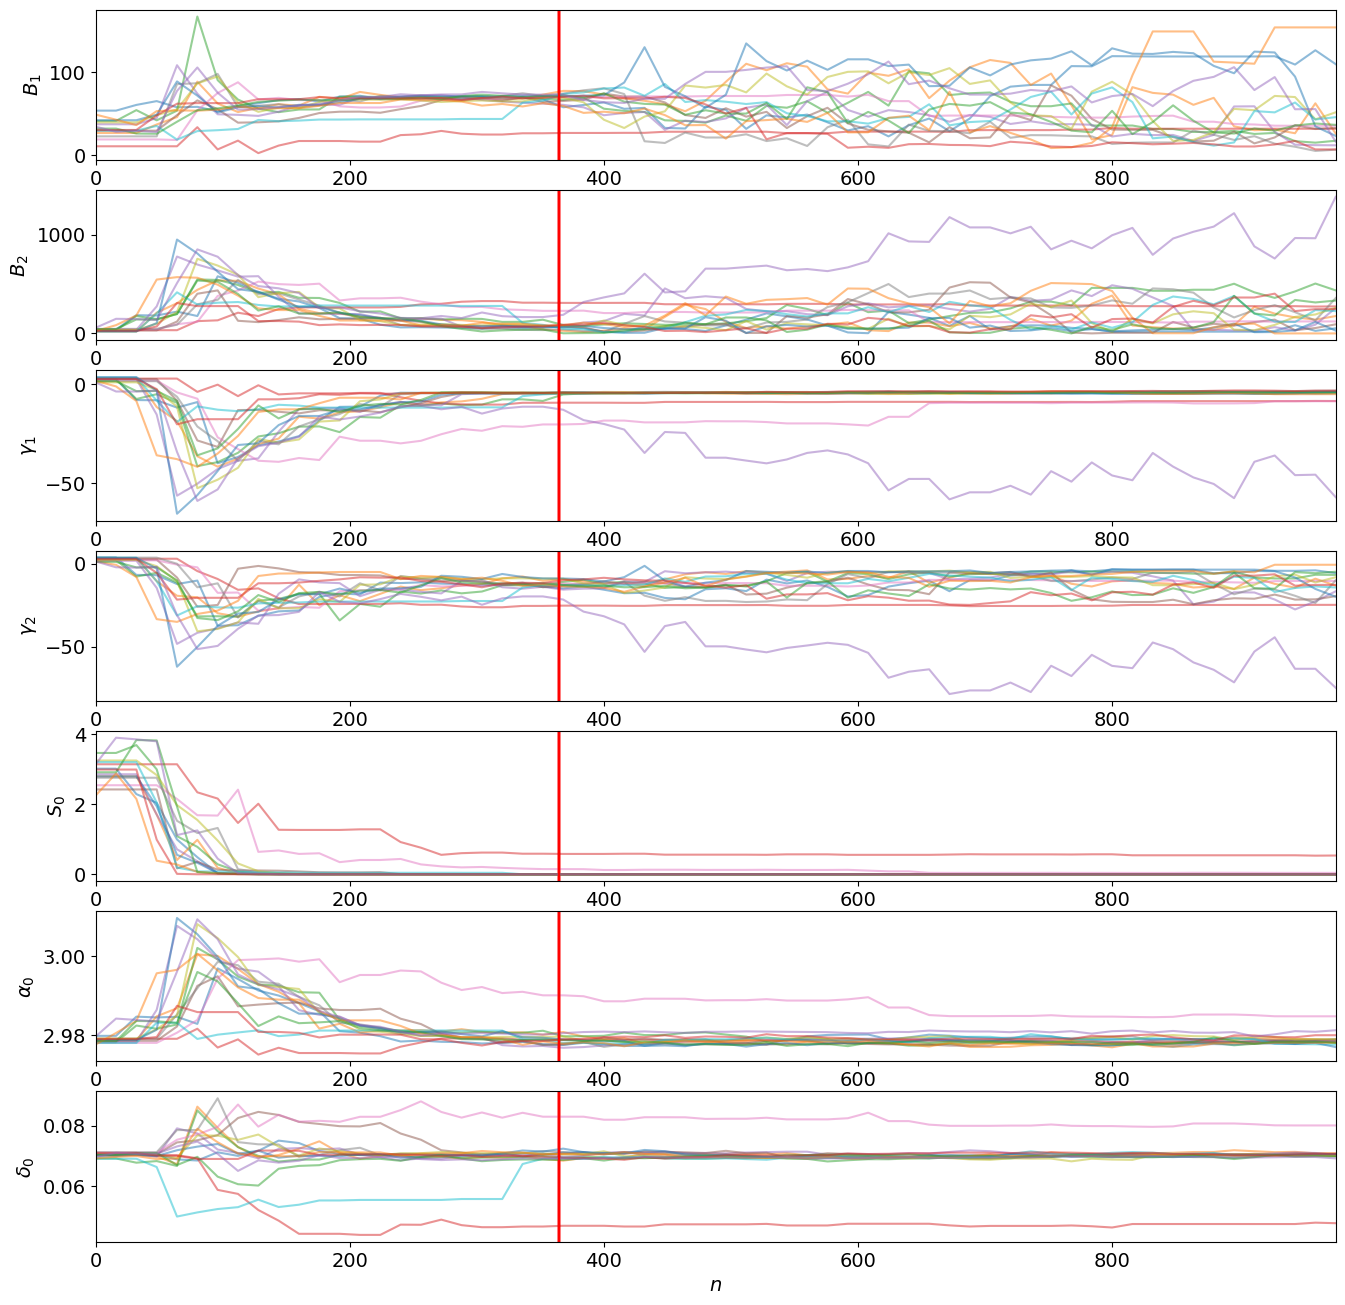

In [142]:
fig,ax = plt.subplots(ndim,1,figsize=(16,16))
labels = [r'$B_1$',r'$B_2$',r'$\gamma_1$',r'$\gamma_2$',r'$S_0$',r'$\alpha_0$',r'$\delta_0$']
for j in range(ndim):
    for i in range(nwalkers):
        ax[j].plot(thin*np.arange(len(samples_w)),samples_w[:,i,j],alpha=0.5)
        ax[j].set_xlim(0,thin*(len(samples_w)-1))
        #ax[j].set_xlim(0,vec_n[-1])
        ax[j].axvline(burnin,color='red')
        ax[j].set_ylabel(labels[j])
ax[ndim-1].set_xlabel(r'$n$');

### Corner

In [65]:
units = np.asarray([1,1,1,1,1e4,180/np.pi,180/np.pi])
samples_units = np.transpose(np.diag(units) @ np.transpose(samples))
p_out_units = np.asarray([np.percentile(samples_units[:,i],[1,16,50,84,99]) for i in range(np.shape(samples_units)[1])])

In [67]:
print('fiducial solar position = ['+str((ra_sun_fid * units[5], dec_sun_fid * units[6]))+' +/- '+ str(sigma_sun * units[4])[:5]+'] deg')

fiducial solar position = [(170.66855149, 4.02092024) +/- 5.817] deg


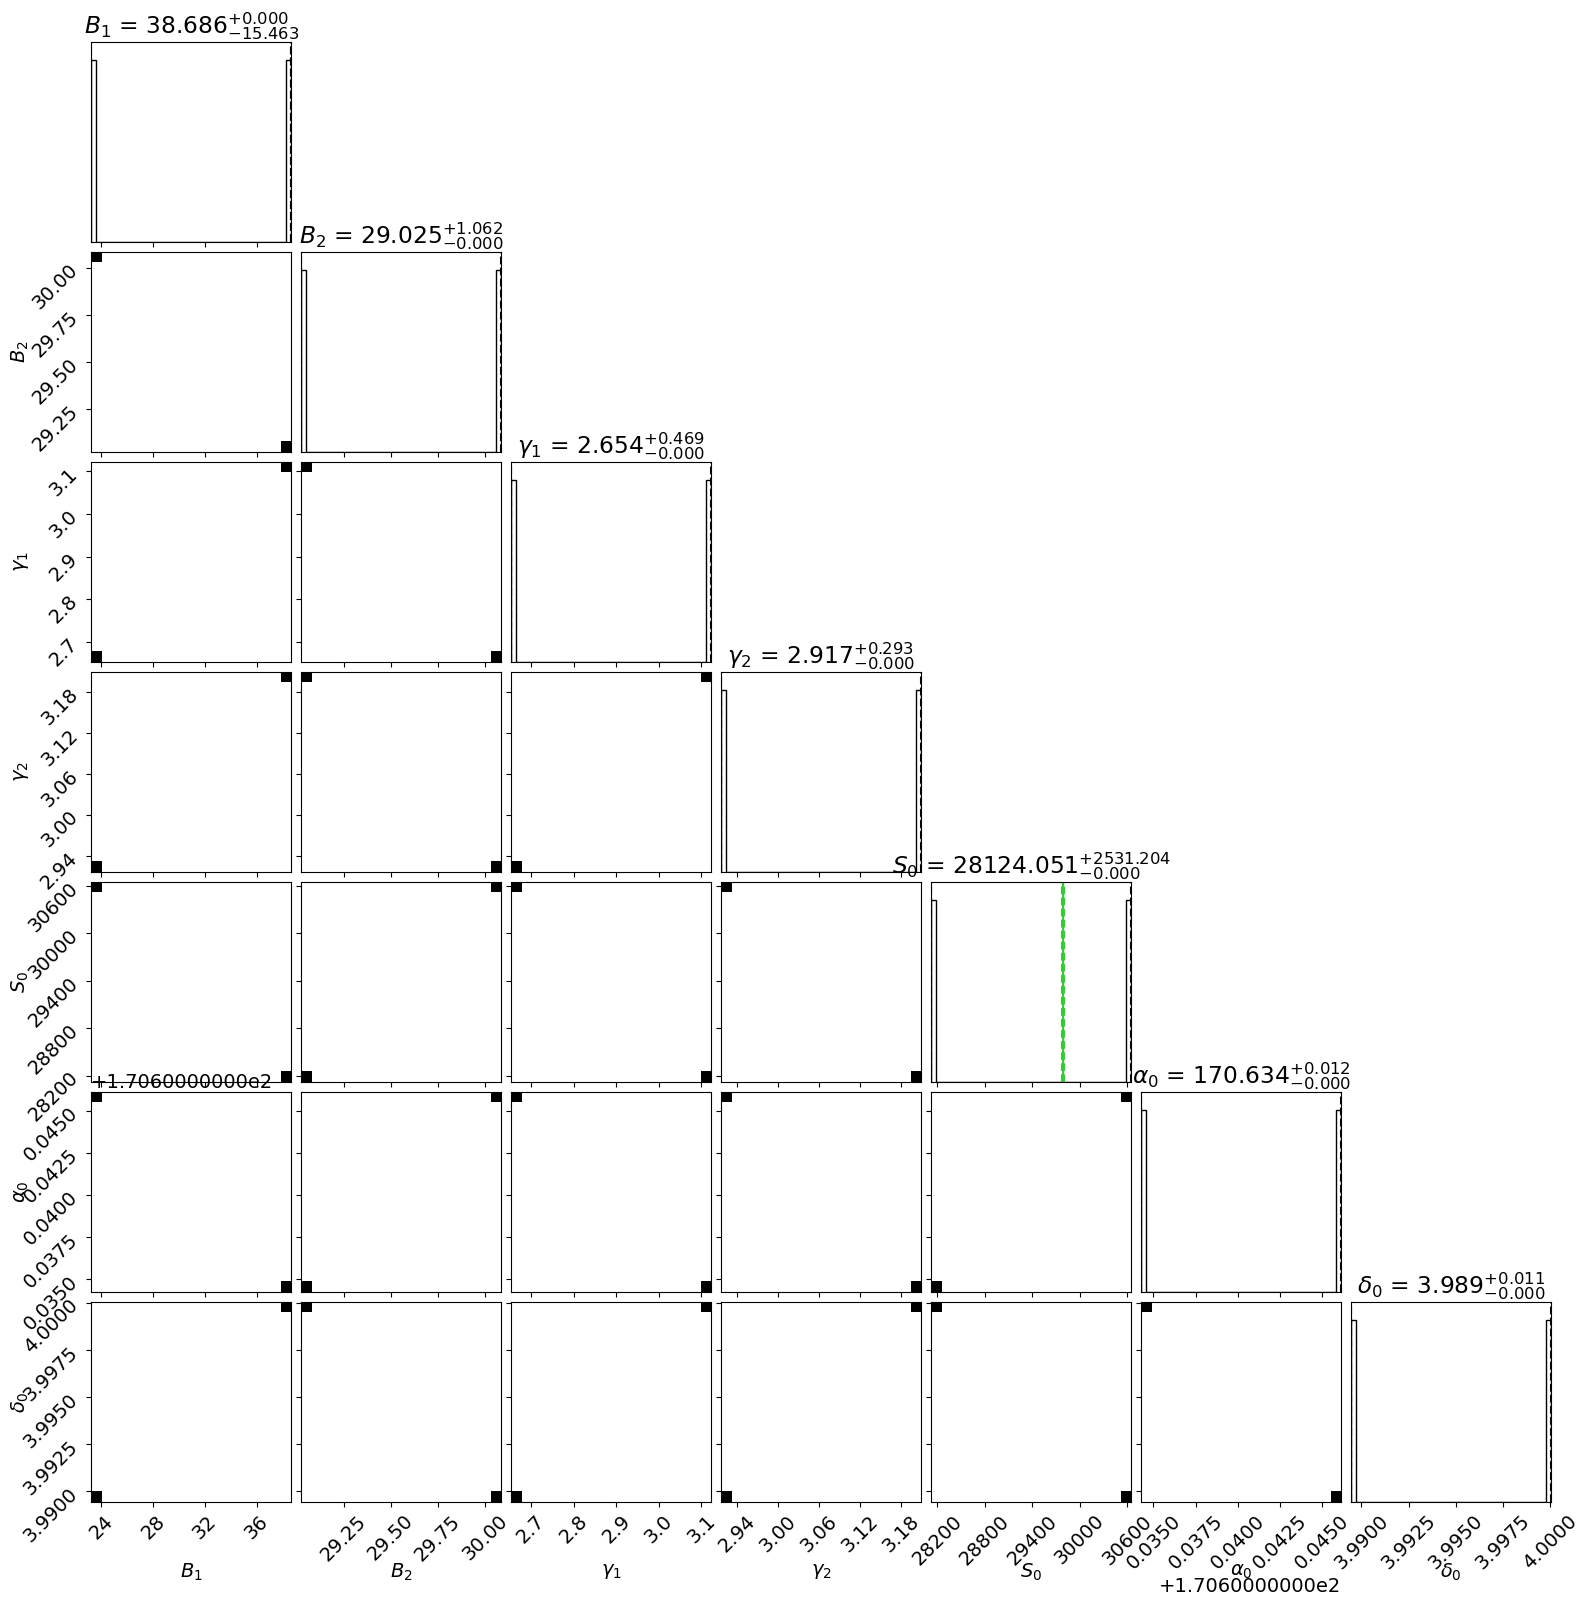

In [68]:
labels = [r'$B_1$',r'$B_2$',r'$\gamma_1$',r'$\gamma_2$',r'$S_0$',r'$\alpha_0$',r'$\delta_0$']
fig = corner.corner(samples_units[:],
              labels=labels,show_titles=True,title_fmt='.3f',
              scale_hist=False,hist_bin_factor=2,range=p_out_units[:,[0,-1]],
              top_ticks=False,quantiles=[0.05,0.5,0.95],verbose=False);
# Extract the axes
ax = np.array(fig.axes).reshape((ndim, ndim))
ax[4,4].axvline(ra_sun_fid * units[4],color=(0.2,0.8,0.2));
ax[4,4].axvline((ra_sun_fid + 2*sigma_sun) * units[4],color=(0.2,0.8,0.2),ls='dashed');
ax[4,4].axvline((ra_sun_fid - 2*sigma_sun) * units[4],color=(0.2,0.8,0.2),ls='dashed');
ax[5,5].axvline(dec_sun_fid * units[5],color=(0.2,0.8,0.2));
ax[5,5].axvline((dec_sun_fid + 2*sigma_sun) * units[5],color=(0.2,0.8,0.2),ls='dashed');
ax[5,5].axvline((dec_sun_fid - 2*sigma_sun) * units[5],color=(0.2,0.8,0.2),ls='dashed');

### Spectra

In [28]:
counts_sig = S0_fit * eps * T_flux_template(t,ra,dec,ra_sun_0,dec_sun_0,delta_ra_sun,delta_dec_sun,t_min,duration)*np.exp(-(E-m/2)**2/(2*sigma_E**2)) / np.sqrt(2 * np.pi * sigma_E**2)

In [29]:
E_bin_size_1 = 0.04;
bins_E_hist_0 = np.logspace(np.log10(3),np.log10(200),150)
bins_E_hist_1 = np.arange(1.98-E_bin_size_1,220+E_bin_size_1,E_bin_size_1)

counts_hist_B1_0 = B1_fit * int_rate_aCXB_bg(bins_E_hist_0[:-1]) * exposure * (bins_E_hist_0[1:] - bins_E_hist_0[:-1])
counts_hist_B2_0 = B2_fit * int_rate_internal_bg(bins_E_hist_0[:-1]) * exposure * (bins_E_hist_0[1:] - bins_E_hist_0[:-1])
counts_hist_B3_0 = B3_fit * int_rate_continuum_bg(bins_E_hist_0[:-1]) * exposure * (bins_E_hist_0[1:] - bins_E_hist_0[:-1])

counts_hist_B1_1 = B1_fit * int_rate_aCXB_bg(bins_E_hist_1[:-1]) * exposure * (bins_E_hist_1[1:] - bins_E_hist_1[:-1])
counts_hist_B2_1 = B2_fit * int_rate_internal_bg(bins_E_hist_1[:-1]) * exposure * (bins_E_hist_1[1:] - bins_E_hist_1[:-1])
counts_hist_B3_1 = B3_fit * int_rate_continuum_bg(bins_E_hist_1[:-1]) * exposure * (bins_E_hist_1[1:] - bins_E_hist_1[:-1])

In [30]:
counts_hist_S0_0 = np.histogram(E,weights=counts_sig,bins=bins_E_hist_0)[0]
counts_hist_S0_1 = np.histogram(E,weights=counts_sig,bins=bins_E_hist_1)[0]

counts_hist_tot_0 = counts_hist_B1_0 + counts_hist_B2_0 + counts_hist_B3_0 + counts_hist_S0_0
counts_hist_tot_1 = counts_hist_B1_1 + counts_hist_B2_1 + counts_hist_B3_1 + counts_hist_S0_1

In [31]:
counts_hist_obs_m_0 = np.histogram(E,weights=counts,bins=bins_E_hist_0)[0]
counts_hist_obs_m_1 = np.histogram(E,weights=counts,bins=bins_E_hist_1)[0]
counts_hist_obs_not_m_0 = np.histogram(E_not_m,weights=counts_not_m,bins=bins_E_hist_0)[0]
counts_hist_obs_not_m_1 = np.histogram(E_not_m,weights=counts_not_m,bins=bins_E_hist_1)[0]

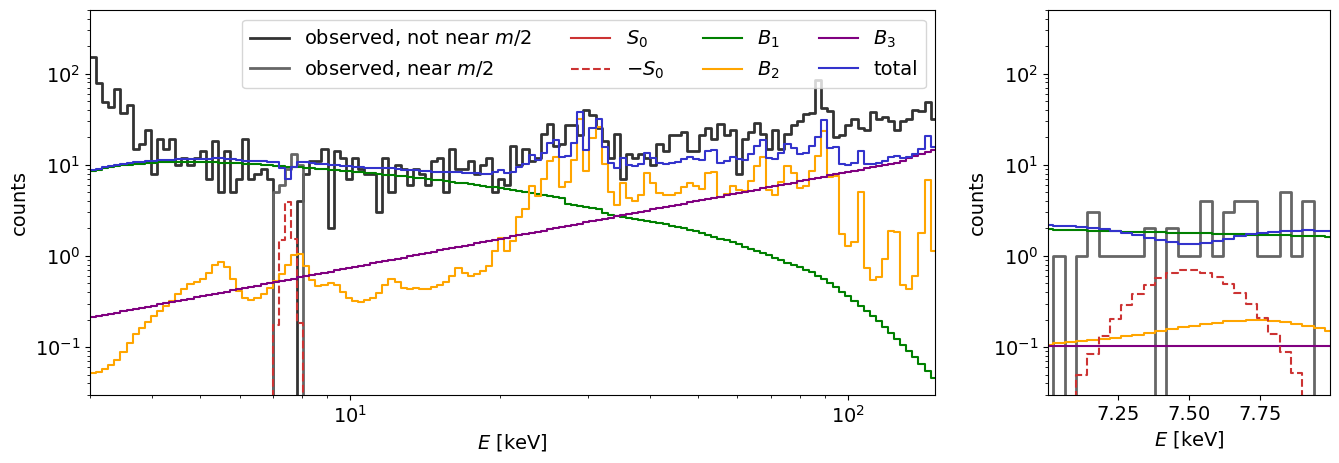

In [32]:
fig,ax = plt.subplots(1,2,gridspec_kw={'width_ratios':[3,1]},figsize=(16,5))
#ax[0].hist(E_not_m,weights=counts_not_m,bins=bins_E_hist_0,histtype='step',color=(0.2,0.2,0.2),label=r'observed, not near $m/2$',lw=2);
#ax[0].hist(E,weights=counts,bins=bins_E_hist_0,histtype='step',color=(0.4,0.4,0.4),label=r'observed, near $m/2$',lw=2)
ax[0].step(bins_E_hist_0[:-1],counts_hist_obs_not_m_0,where='post',color=(0.2,0.2,0.2),label=r'observed, not near $m/2$',lw=2)
ax[0].step(bins_E_hist_0[:-1],counts_hist_obs_m_0,where='post',color=(0.4,0.4,0.4),label=r'observed, near $m/2$',lw=2)
ax[0].step(bins_E_hist_0[:-1],counts_hist_S0_0,where='post',color=(0.8,0.2,0.2),label=r'$S_0$')
ax[0].step(bins_E_hist_0[:-1],-counts_hist_S0_0,where='post',ls='dashed',color=(0.8,0.2,0.2),label=r'$-S_0$')
ax[0].step(bins_E_hist_0[:-1],counts_hist_B1_0,where='post',color='green',label=r'$B_1$')
ax[0].step(bins_E_hist_0[:-1],counts_hist_B2_0,where='post',color='orange',label=r'$B_2$')
ax[0].step(bins_E_hist_0[:-1],counts_hist_B3_0,where='post',color='purple',label=r'$B_3$')
ax[0].step(bins_E_hist_0[:-1],counts_hist_tot_0,where='post',color=(0.2,0.2,0.8),label='total')
#ax[0].hist(E,weights=counts_sig,bins=bins_E_hist_0,histtype='step',color=(0.8,0.2,0.2),label=r'$S_0$')
#ax[1].hist(E,weights=counts,bins=bins_E_hist_1,histtype='step',color=(0.4,0.4,0.4),label=r'observed, near $m$',lw=2)
ax[1].step(bins_E_hist_1[:-1],counts_hist_obs_m_1,where='post',color=(0.4,0.4,0.4),label=r'observed, near $m$',lw=2)
ax[1].step(bins_E_hist_1[:-1],counts_hist_B1_1,where='post',color='green',label=r'$B_1$')
ax[1].step(bins_E_hist_1[:-1],counts_hist_B2_1,where='post',color='orange',label=r'$B_2$')
ax[1].step(bins_E_hist_1[:-1],counts_hist_B3_1,where='post',color='purple',label=r'$B_3$')
ax[1].step(bins_E_hist_1[:-1],counts_hist_S0_1,where='post',color=(0.8,0.2,0.2),label=r'$S_0$')
ax[1].step(bins_E_hist_1[:-1],-counts_hist_S0_1,where='post',ls='dashed',color=(0.8,0.2,0.2),label=r'$-S_0$')
ax[1].step(bins_E_hist_1[:-1],counts_hist_tot_1,where='post',color=(0.2,0.2,0.8),label='total')
#ax[1].hist(E,weights=counts_sig,bins=bins_E_hist_1,histtype='step',color=(0.8,0.2,0.2),label=r'$S_0$')


ax[0].set_xlim(3,150)
ax[1].set_xlim(m/2-n_sigma_E*sigma_E,m/2+n_sigma_E*sigma_E)
ax[0].set_xscale('log'); ax[0].set_yscale('log'); 
ax[1].set_xscale('linear'); ax[1].set_yscale('log'); 
for i in range(2):
    ax[i].set_xlabel(r'$E~[\mathrm{keV}]$'); ax[i].set_ylabel(r'counts');
    ax[i].set_ylim(3e-2,5e2)
ax[0].legend(ncol=4,loc='upper right');
#ax[1].legend(loc='lower right');

### Time dependence

## Limit

In [33]:
cdf_samples = stats.cumfreq(samples[:,3],numbins=10**6)

In [34]:
S0_cdf_array = cdf_samples.lowerlimit + np.linspace(0, cdf_samples.binsize*cdf_samples.cumcount.size,cdf_samples.cumcount.size)

In [35]:
cdf_S0_interpolation = interp1d(S0_cdf_array,cdf_samples.cumcount/samples_units.shape[0],bounds_error=False,fill_value=(1e-20,1))

In [36]:
def fun_intersect_unconstrained(S0,alpha=0.1):
    return (1-cdf_S0_interpolation(S0))-alpha

def fun_intersect_CLs(S0,alpha=0.1):
    return (1-cdf_S0_interpolation(S0))/(1-cdf_S0_interpolation(0))-alpha

In [41]:
S0_lim_unconstrained = optimize.brentq(fun_intersect_unconstrained,S0_cdf_array[0],S0_cdf_array[-1])
S0_lim_CLs = optimize.brentq(fun_intersect_CLs,S0_cdf_array[0],S0_cdf_array[-1])

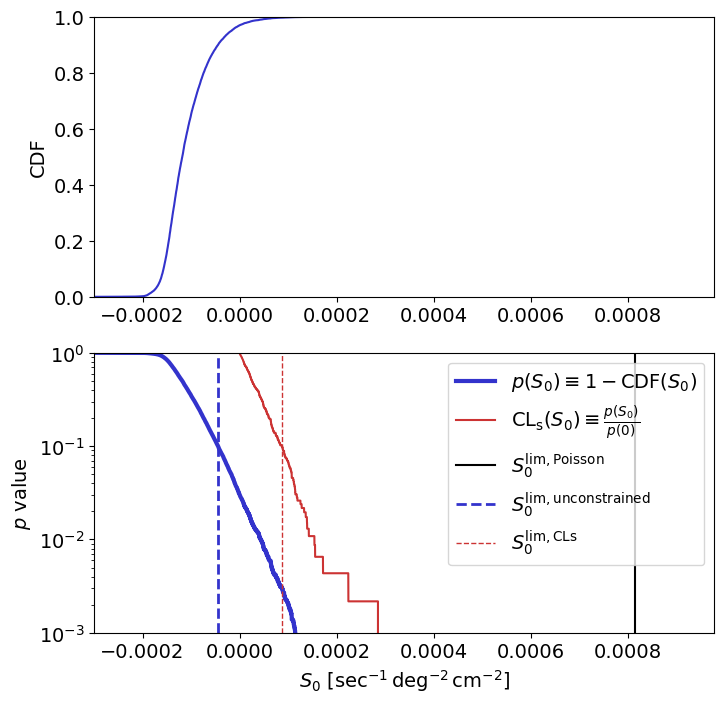

In [62]:
fig,ax = plt.subplots(2,1,figsize=(8,8))
ax[0].set_xlim(S0_cdf_array[0],np.max([S0_cdf_array[-1],1.2*S0_guess]))
ax[0].set_ylim(0,1);
ax[0].plot(S0_cdf_array,cdf_S0_interpolation(S0_cdf_array),color=(0.2,0.2,0.8))
ax[0].set_ylabel('CDF');
ax[1].set_xlim(S0_cdf_array[0],np.max([S0_cdf_array[-1],1.2*S0_guess]))
ax[1].set_ylim(1e-3,1); ax[1].set_yscale('log')
h0, = ax[1].plot(S0_cdf_array,1-cdf_S0_interpolation(S0_cdf_array),lw=3,color=(0.2,0.2,0.8))
h1, = ax[1].plot(S0_cdf_array,(1-cdf_S0_interpolation(S0_cdf_array))/(1-cdf_S0_interpolation(0)),lw=1.5,color=(0.8,0.2,0.2))
h2 = ax[1].axvline(S0_guess,color=(0,0,0))
#h3 = ax[1].axvline(df_results['S_0_lim_yellin'][idx_m],color='orange')
h4 = ax[1].axvline(S0_lim_unconstrained,ls='dashed',lw=2,color=(0.2,0.2,0.8))#,label=r'$S_0^{\text{lim,unconstrained}}$')
h5 = ax[1].axvline(S0_lim_CLs,ls='dashed',lw=1,color=(0.8,0.2,0.2))#label=r'$S_0^{\text{lim,CLs}}$')
ax[1].set_ylabel(r'$p$ value');
ax[1].set_xlabel(r'$S_0 ~[\mathrm{sec^{-1}\,deg^{-2}\,cm^{-2}}]$')
ax[1].legend([h0,h1,h2,h4,h5],[r'$p(S_0) \equiv 1-\mathrm{CDF}(S_0)$',r'$\mathrm{CL_s}(S_0) \equiv \frac{p(S_0)}{p(0)}$',
                            '$S_0^{\mathrm{lim,Poisson}}$',#'$S_0^{\mathrm{lim,Yellin}}$',
                            '$S_0^{\mathrm{lim,unconstrained}}$','$S_0^{\mathrm{lim,CLs}}$']);
#ax[1].legend([h0,h1,h2,h3,h4,h5],[r'$p(S_0) \equiv 1-\mathrm{CDF}(S_0)$',r'$\mathrm{CL_s}(S_0) \equiv \frac{p(S_0)}{p(0)}$',
#                                  '$S_0^{\mathrm{lim,Poisson}}$','$S_0^{\mathrm{lim,Yellin}}$','$S_0^{\mathrm{lim,unconstrained}}$','$S_0^{\mathrm{lim,CLs}}$']);